## Discrete Optimization #2 - Qatar

__[Traveling Salesman Problem](http://www.math.uwaterloo.ca/tsp/world/countries.html)__ - 194 cities (Qatar)

find the shortest path, so you visit all cities without visiting the same twice.

In [1]:
import tsplib95
import numpy as np
from timeit import default_timer as timer
from scipy.spatial.distance import squareform
import random
import string
from deap import base, creator, tools
import matplotlib.pyplot as plt

In [2]:
Qatar = tsplib95.load('qa194.tsp')

In [3]:
Qatar.as_name_dict()

{'name': 'qa194',
 'comment': 'Derived from National Imagery and Mapping Agency data',
 'type': 'TSP',
 'dimension': 194,
 'edge_weight_type': 'EUC_2D',
 'node_coords': {1: [24748.3333, 50840.0],
  2: [24758.8889, 51211.9444],
  3: [24827.2222, 51394.7222],
  4: [24904.4444, 51175.0],
  5: [24996.1111, 51548.8889],
  6: [25010.0, 51039.4444],
  7: [25030.8333, 51275.2778],
  8: [25067.7778, 51077.5],
  9: [25100.0, 51516.6667],
  10: [25103.3333, 51521.6667],
  11: [25121.9444, 51218.3333],
  12: [25150.8333, 51537.7778],
  13: [25158.3333, 51163.6111],
  14: [25162.2222, 51220.8333],
  15: [25167.7778, 51606.9444],
  16: [25168.8889, 51086.3889],
  17: [25173.8889, 51269.4444],
  18: [25210.8333, 51394.1667],
  19: [25211.3889, 51619.1667],
  20: [25214.1667, 50807.2222],
  21: [25214.4444, 51378.8889],
  22: [25223.3333, 51451.6667],
  23: [25224.1667, 51174.4444],
  24: [25233.3333, 51333.3333],
  25: [25234.1667, 51203.0556],
  26: [25235.5556, 51330.0],
  27: [25235.5556, 51495.55

In [4]:
def calculate_edge_weights(tsproblem): 
    N = tsproblem.dimension
    edges_list = []
    for x in range(1, N+1): 
        for y in range(x+1, N+1):
            current_weight = tsproblem.get_weight(x, y)
            edges_list.append(current_weight)

    return edges_list

In [5]:
def calculate_distance_matrix(tsproblem): 
    N = tsproblem.dimension
    edges_list = []
    for x in range(1, N+1): 
        current_point = []
        for y in range(x+1, N+1):
            current_weight = tsproblem.get_weight(x, y)
            current_point.append(current_weight)
        edges_list.append(current_point)
            
    edges = squareform(np.hstack(edges_list)) # complete distances matrix
    return edges

In [6]:
calculate_distance_matrix(Qatar)

array([[   0.,  372.,  560., ..., 1435., 1459., 1427.],
       [ 372.,    0.,  195., ..., 1374., 1377., 1395.],
       [ 560.,  195.,    0., ..., 1318., 1310., 1354.],
       ...,
       [1435., 1374., 1318., ...,    0.,   83.,  110.],
       [1459., 1377., 1310., ...,   83.,    0.,  193.],
       [1427., 1395., 1354., ...,  110.,  193.,    0.]])

In [7]:
## DEAP Genetic Algorithm

In [8]:
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [32]:
## globals,

random.seed(11);
np.random.seed(121);


INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 194 # N
POPULATION_SIZE = 388 # N * 2
N_ITERATIONS = 3880 # N * 10 
N_MATINGS = 97 # N / 2

## city indexes
cities = list(Qatar.get_nodes())

## distances calculated 
distances = calculate_distance_matrix(Qatar)

In [33]:
## Min.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)

## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [34]:
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

toolbox.register("evaluate", EVALUATE)

In [35]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01) # mutation rate
toolbox.register("select", tools.selTournament, tournsize=10) # selection 

In [36]:
start = timer()
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()
end = timer()
elapsed_time = end - start

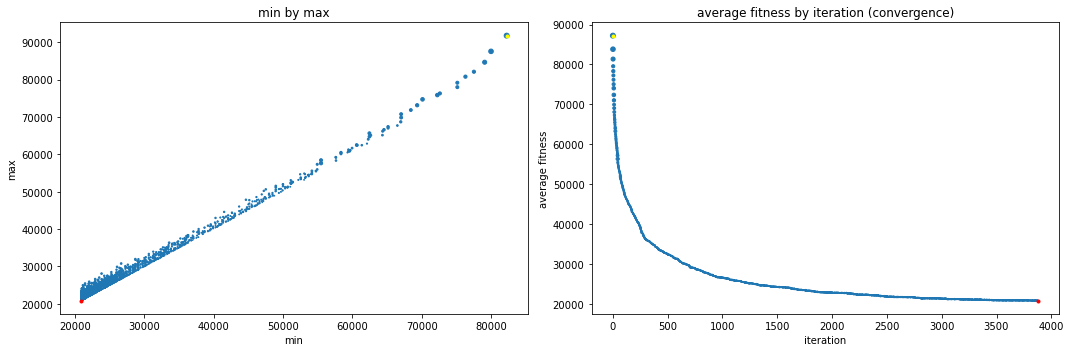

In [37]:
## create plots

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')

_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('average fitness by iteration (convergence)')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average fitness')

_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [39]:
## results 

fitnesses = sorted([ 
    (i, toolbox.evaluate(individual)) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])
best_individual = tools.selBest(population, k=1)[0]

print('RESULTS')
print('Best individual (path): ', best_individual)
print('Fitness of the best individual: ', EVALUATE(best_individual))
print('Convergence (top 5 individuals): ', fitnesses[:5])
print('Computation time (seconds): ', elapsed_time)

RESULTS
Best individual (path):  [117, 121, 126, 129, 97, 85, 112, 108, 101, 78, 80, 99, 109, 111, 114, 115, 135, 149, 137, 133, 131, 110, 93, 88, 81, 79, 86, 100, 103, 113, 122, 123, 127, 132, 128, 120, 116, 104, 105, 77, 74, 68, 59, 56, 21, 11, 14, 18, 119, 165, 170, 179, 177, 180, 183, 160, 155, 144, 139, 3, 1, 0, 19, 64, 84, 20, 17, 36, 38, 33, 39, 42, 45, 51, 52, 47, 40, 37, 30, 26, 28, 27, 32, 25, 23, 73, 90, 157, 158, 164, 176, 187, 190, 188, 189, 186, 185, 168, 145, 118, 102, 92, 87, 82, 71, 24, 13, 12, 22, 75, 147, 159, 142, 134, 96, 91, 76, 69, 63, 67, 65, 66, 60, 54, 49, 34, 31, 29, 41, 48, 43, 46, 50, 44, 94, 95, 125, 124, 136, 138, 143, 140, 146, 150, 151, 153, 163, 162, 148, 141, 70, 6, 2, 4, 9, 8, 16, 10, 5, 7, 15, 61, 58, 35, 62, 89, 98, 172, 173, 182, 174, 156, 152, 106, 107, 83, 72, 57, 55, 53, 130, 154, 161, 184, 192, 191, 193, 181, 175, 171, 178, 167, 166, 169]
Fitness of the best individual:  20886.0
Convergence (top 5 individuals):  [(0, 20886.0), (1, 20886.0), (2

## Conclusion 

*The chosen algorithm*

I implemented the Genetic Algorithm for TSP in this case as the algorithm is easy to understand, allowing for more ability to experiment with the parameters than other algorithms. As the population and individual sizes are relatively small, the time cost of the implementation is essentially the same as other algorithms (though it has been noted that Simmulated Annealing is more efficient to solve large TSP problems than GA implementation), which had me prioritize the implementation which would allow for experimentation and parameter selection easily with the DEAP library.

*The parameters of the algorithm*

- Fitness - each individual is evaluated as the sum of the distances between each city, in the order of the individual's chromosome (see EVALUATE function)
- Mate - used __[DEAP cxOrdered](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered)__, as we cannot drop any cities and the order of the cities matter to get the most from the parent's fitness increases over time. 
- Mutate - used __[DEAP mutShuffleIndexes](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes)__, with probablity 1%. Mutation rate was kept as 1% as we have a larger population size which will have more diversity built-in.

*The final results, both solution and fitness, computational time, and convergence curve can be seen above*



*The number of function evaluations or stopping criterion*

The number of iterations was determined by experimentation (see Notes). The increased population size returns lower fitness scores, however it does take much longer each time, so I limited the maximum at N * 20, or 3880 iterations. 


## Notes 

__[TSBLIP95](https://tsplib95.readthedocs.io/en/stable/pages/usage.html#rendering-problems)__

__[DEAP](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes)__

__[Genetic Algorithm: The Travelling Salesman Problem via Python, DEAP](https://medium.com/@pasdan/genetic-algorithm-the-travelling-salesman-problem-via-python-deap-f238e0dd1a73)__

__[Solving the TSP with GAs](https://notebook.community/40423140/123456/content/notebook/Solving%20the%20TSP%20with%20GAs)__

**Iteration tests**

For POPULATION_SIZE = 194 (N * 2) and N_MATINGS = 97 (N / 2), mutation rate of 1%, I had the following results: 
970 (N * 5) = 26699.0,
1940 (N * 10) = 22896.0 (starting point),
2910 (N * 15) = 21426.0,
3880 (N * 20) = 20886,
indicating an optimal point of accuracy and speed at N * 20, 3880. This does have the highest computation time.

